# NB05: Model Scaling

**Question:** Can small models + premium retrieval match larger models without retrieval?

This notebook explores the scaling relationship:
- Direct performance vs model size
- RAG uplift vs model size
- Whether small+RAG can compensate for model size
- What matters most for small vs medium models

In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats

from analysis_utils import (
    load_all_results, setup_plotting, identify_bottlenecks,
    weighted_mean_with_ci, multi_metric_bottlenecks_df, facet_by_dataset,
    PRIMARY_METRIC, MODEL_PARAMS, MODEL_TIER, BROKEN_MODELS,
    MULTI_METRIC_SET, GROUNDEDNESS_METRICS, CONTEXT_METRICS,
    DATASET_COLORS, DATASET_MARKERS, DATASET_LABELS,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

df_all = load_all_results(STUDY_PATH)
df = df_all[~df_all['model_short'].isin(BROKEN_MODELS)].copy()

# Add parameter count and tier columns
df['params_b'] = df['model_short'].map(MODEL_PARAMS)
df['tier'] = df['model_short'].map(MODEL_TIER)
print(f"Loaded {len(df)} experiments")
print(f"Models with params: {df['params_b'].notna().sum()}")
print(f"Tiers: {df['tier'].value_counts().to_dict()}")

# Check available metrics
available_metrics = [m for m in MULTI_METRIC_SET if m in df.columns and df[m].notna().sum() >= 10]
print(f"\nAvailable metrics: {available_metrics}")


  356 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 327 exps — iterative
  Deduplicated: dropped 249 duplicate experiments (same effective config, kept best F1)
Loaded 717 experiments
Models with params: 717
Tiers: {'medium': 291, 'small': 218, 'tiny': 208}

Available metrics: ['f1', 'exact_match', 'bertscore_f1', 'faithfulness', 'answer_in_context', 'context_recall']


## 1. Direct Scaling Curve

F1 vs model parameters (log scale) for direct (no-retrieval) experiments.

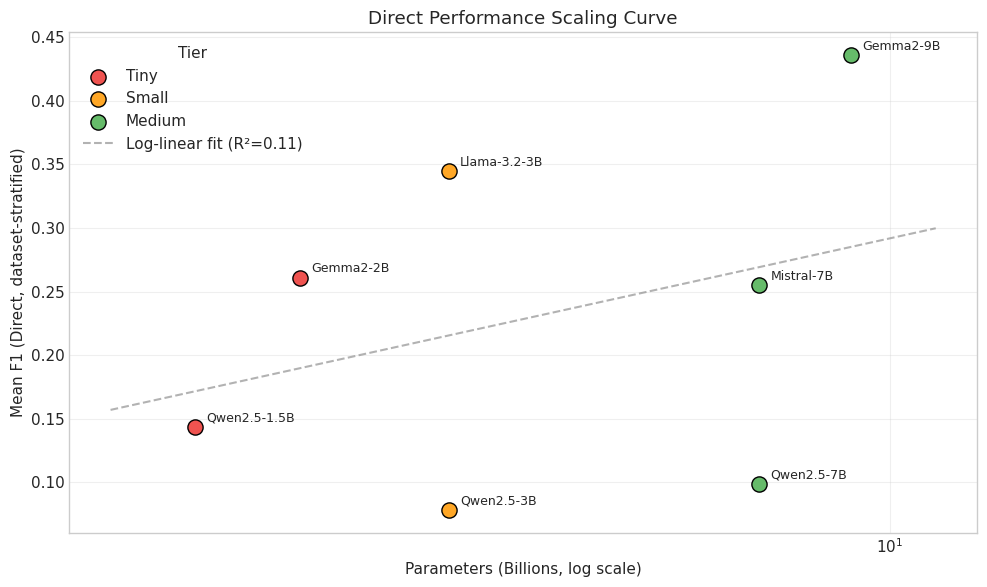

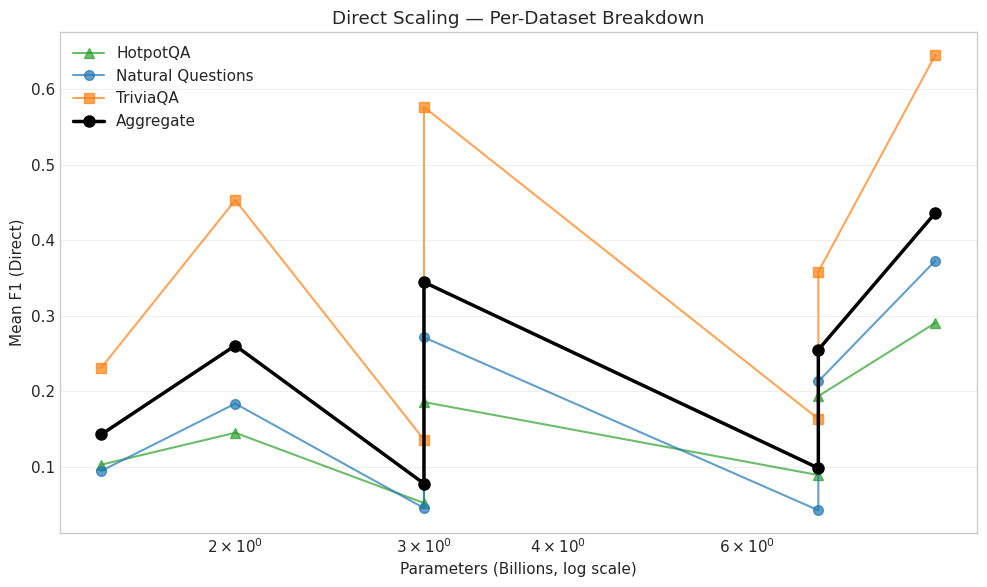

In [11]:
# Stratified: compute mean per (model, dataset), then average across datasets
direct = df[df['exp_type'] == 'direct'].dropna(subset=['params_b', PRIMARY_METRIC])

# Per-model-dataset means, then average across datasets per model
per_ds = direct.groupby(['model_short', 'dataset'])[PRIMARY_METRIC].mean()
model_f1 = per_ds.groupby('model_short').mean()
model_std = per_ds.groupby('model_short').std().fillna(0)
model_n = direct.groupby('model_short')[PRIMARY_METRIC].count()

model_direct = direct.groupby('model_short').agg(
    params_b=('params_b', 'first'),
    tier=('tier', 'first'),
).reset_index()
model_direct['mean_f1'] = model_direct['model_short'].map(model_f1)
model_direct['std_f1'] = model_direct['model_short'].map(model_std)
model_direct['n'] = model_direct['model_short'].map(model_n)

tier_colors = {'tiny': '#ef5350', 'small': '#ffa726', 'medium': '#66bb6a'}

fig, ax = plt.subplots(figsize=(10, 6))

for tier, color in tier_colors.items():
    sub = model_direct[model_direct['tier'] == tier]
    ax.scatter(sub['params_b'], sub['mean_f1'], c=color, s=120,
              label=tier.capitalize(), edgecolors='black', zorder=3)
    for _, row in sub.iterrows():
        ax.annotate(row['model_short'], (row['params_b'], row['mean_f1']),
                    textcoords='offset points', xytext=(8, 4), fontsize=9)

# Log-linear regression
if len(model_direct) >= 3:
    log_params = np.log10(model_direct['params_b'])
    slope, intercept, r, p, se = scipy_stats.linregress(log_params, model_direct['mean_f1'])
    x_fit = np.linspace(log_params.min() - 0.1, log_params.max() + 0.1, 50)
    ax.plot(10**x_fit, slope * x_fit + intercept, '--', color='grey', alpha=0.6,
            label=f'Log-linear fit (R²={r**2:.2f})')

ax.set_xscale('log')
ax.set_xlabel('Parameters (Billions, log scale)')
ax.set_ylabel('Mean F1 (Direct, dataset-stratified)')
ax.set_title('Direct Performance Scaling Curve')
ax.legend(title='Tier')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Per-dataset breakdown: coloured lines per dataset + thick black aggregate ---
datasets = sorted(direct['dataset'].unique())
if len(datasets) >= 2:
    fig, ax = plt.subplots(figsize=(10, 6))

    for ds in datasets:
        ds_direct = direct[direct['dataset'] == ds]
        ds_model = ds_direct.groupby('model_short').agg(
            params_b=('params_b', 'first'),
            mean_f1=(PRIMARY_METRIC, 'mean'),
        ).sort_values('params_b')
        color = DATASET_COLORS.get(ds, 'grey')
        marker = DATASET_MARKERS.get(ds, 'o')
        label = DATASET_LABELS.get(ds, ds)
        ax.plot(ds_model['params_b'], ds_model['mean_f1'],
                marker=marker, color=color, markersize=7, linewidth=1.5,
                alpha=0.7, label=label)

    # Aggregate overlay (thick black)
    agg = model_direct.sort_values('params_b')
    ax.plot(agg['params_b'], agg['mean_f1'],
            'o-', color='black', markersize=8, linewidth=2.5, label='Aggregate', zorder=5)

    ax.set_xscale('log')
    ax.set_xlabel('Parameters (Billions, log scale)')
    ax.set_ylabel('Mean F1 (Direct)')
    ax.set_title('Direct Scaling — Per-Dataset Breakdown')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2. RAG Uplift by Model Size

Overlay best-RAG curve on direct curve — the key thesis figure.

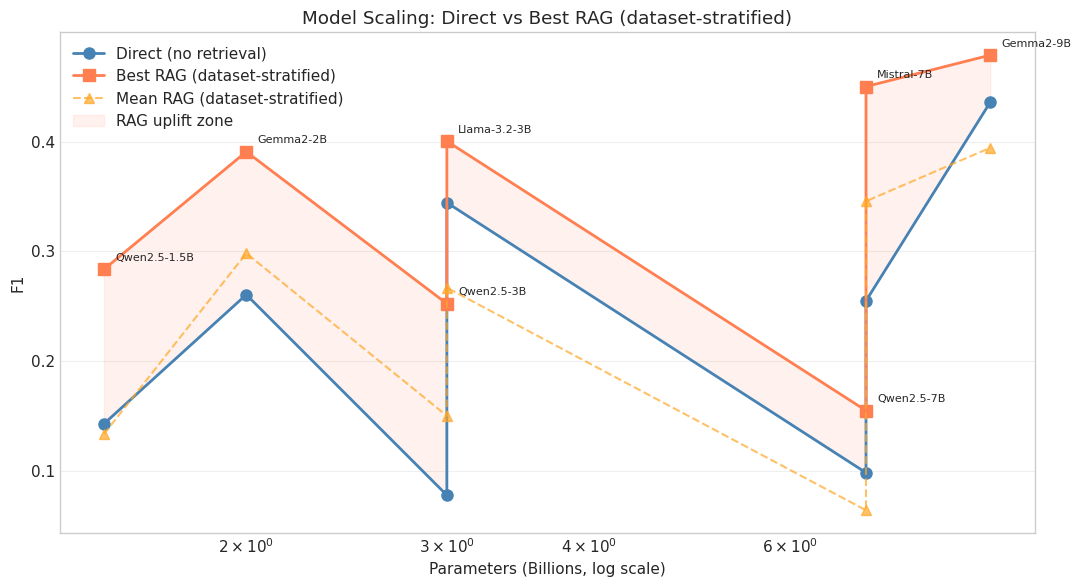

,model_short,direct_f1,params_b,tier,best_rag_f1,mean_rag_f1,rag_uplift
0,Gemma2-2B,0.2607,2.0,tiny,0.3909,0.2983,0.1302
1,Gemma2-9B,0.4360,9.0,medium,0.4789,0.3945,0.0428
2,Llama-3.2-3B,0.3445,3.0,small,0.4005,0.2670,0.0560
3,Mistral-7B,0.2550,7.0,medium,0.4502,0.3458,0.1952
4,Qwen2.5-1.5B,0.1430,1.5,tiny,0.2837,0.1337,0.1407
5,Qwen2.5-3B,0.0780,3.0,small,0.2524,0.1503,0.1745
6,Qwen2.5-7B,0.0985,7.0,medium,0.1550,0.0643,0.0566


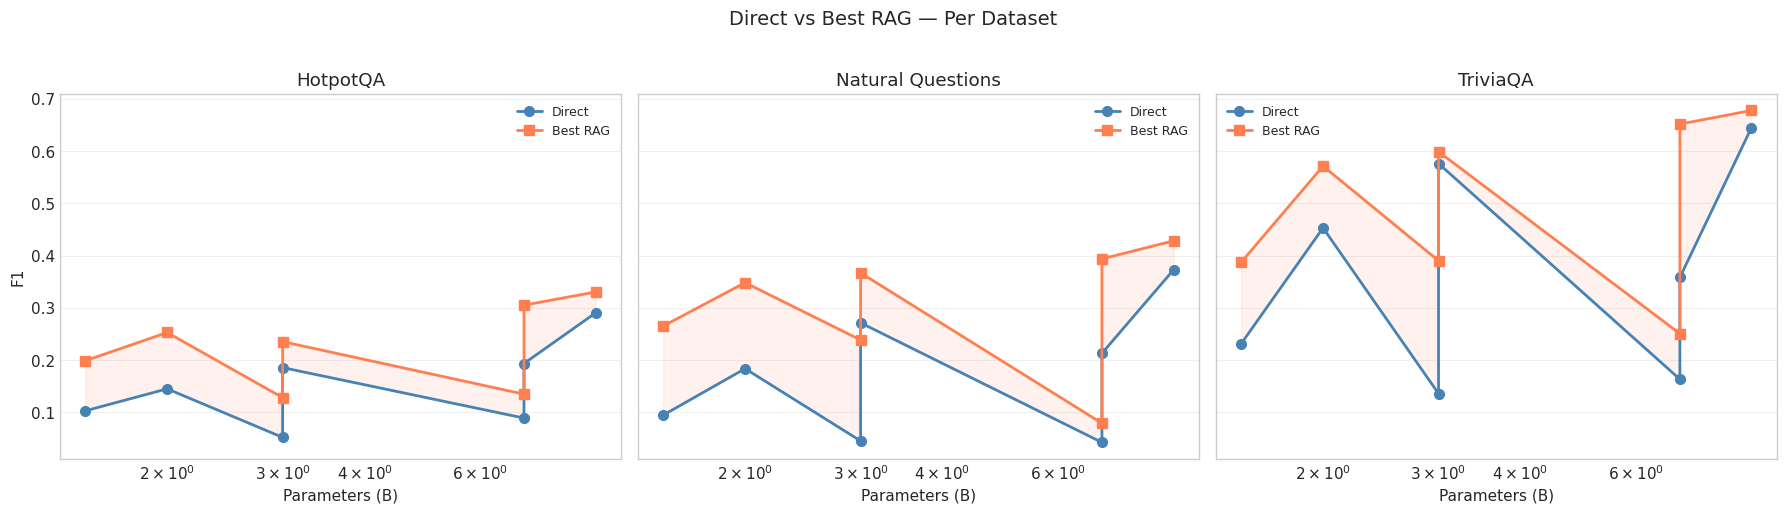

In [12]:
# Stratified: compute best/mean RAG per (model, dataset), then average across datasets
rag_df = df[df['exp_type'] == 'rag'].dropna(subset=['params_b', PRIMARY_METRIC])

per_ds_rag = rag_df.groupby(['model_short', 'dataset'])[PRIMARY_METRIC].agg(['max', 'mean'])
per_ds_rag.columns = ['best_rag_f1', 'mean_rag_f1']
model_rag_agg = per_ds_rag.groupby('model_short').mean().reset_index()

model_best_rag = rag_df.groupby('model_short').agg(
    params_b=('params_b', 'first'),
    tier=('tier', 'first'),
).reset_index().merge(model_rag_agg, on='model_short')

# Merge direct and RAG data
scaling = model_direct[['model_short', 'mean_f1', 'params_b', 'tier']].rename(
    columns={'mean_f1': 'direct_f1'}
).merge(model_best_rag[['model_short', 'best_rag_f1', 'mean_rag_f1']], on='model_short', how='outer')
scaling['rag_uplift'] = scaling['best_rag_f1'] - scaling['direct_f1']

fig, ax = plt.subplots(figsize=(11, 6))

# Sort by params for line plot
scaling_sorted = scaling.dropna(subset=['params_b']).sort_values('params_b')

ax.plot(scaling_sorted['params_b'], scaling_sorted['direct_f1'],
        'o-', color='steelblue', markersize=8, label='Direct (no retrieval)', linewidth=2)
ax.plot(scaling_sorted['params_b'], scaling_sorted['best_rag_f1'],
        's-', color='coral', markersize=8, label='Best RAG (dataset-stratified)', linewidth=2)
ax.plot(scaling_sorted['params_b'], scaling_sorted['mean_rag_f1'],
        '^--', color='#ffa726', markersize=7, label='Mean RAG (dataset-stratified)', linewidth=1.5, alpha=0.7)

# Annotate models
for _, row in scaling_sorted.iterrows():
    ax.annotate(row['model_short'], (row['params_b'], row['best_rag_f1']),
                textcoords='offset points', xytext=(8, 6), fontsize=8)

# Shade the RAG uplift region
ax.fill_between(scaling_sorted['params_b'],
                scaling_sorted['direct_f1'], scaling_sorted['best_rag_f1'],
                alpha=0.1, color='coral', label='RAG uplift zone')

ax.set_xscale('log')
ax.set_xlabel('Parameters (Billions, log scale)')
ax.set_ylabel('F1')
ax.set_title('Model Scaling: Direct vs Best RAG (dataset-stratified)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

display(scaling.round(4))

# --- Per-dataset faceted: one panel per dataset showing Direct + Best-RAG curves ---
datasets = sorted(set(direct['dataset'].unique()) & set(rag_df['dataset'].unique()))
if len(datasets) >= 2:
    fig, axes = plt.subplots(1, len(datasets), figsize=(6 * len(datasets), 5), sharey=True)
    if len(datasets) == 1:
        axes = [axes]

    for ax_i, ds in zip(axes, datasets):
        # Direct curve for this dataset
        ds_direct = direct[direct['dataset'] == ds].groupby('model_short').agg(
            params_b=('params_b', 'first'),
            mean_f1=(PRIMARY_METRIC, 'mean'),
        ).sort_values('params_b')
        # Best RAG curve for this dataset
        ds_rag = rag_df[rag_df['dataset'] == ds].groupby('model_short').agg(
            params_b=('params_b', 'first'),
            best_f1=(PRIMARY_METRIC, 'max'),
        ).sort_values('params_b')

        ax_i.plot(ds_direct['params_b'], ds_direct['mean_f1'],
                  'o-', color='steelblue', markersize=7, linewidth=2, label='Direct')
        ax_i.plot(ds_rag['params_b'], ds_rag['best_f1'],
                  's-', color='coral', markersize=7, linewidth=2, label='Best RAG')
        # Shade uplift
        merged_ds = ds_direct.join(ds_rag[['best_f1']], how='inner').sort_values('params_b')
        if not merged_ds.empty:
            ax_i.fill_between(merged_ds['params_b'], merged_ds['mean_f1'],
                              merged_ds['best_f1'], alpha=0.1, color='coral')

        ax_i.set_xscale('log')
        ax_i.set_xlabel('Parameters (B)')
        if ax_i is axes[0]:
            ax_i.set_ylabel('F1')
        ax_i.set_title(DATASET_LABELS.get(ds, ds))
        ax_i.legend(fontsize=9)
        ax_i.grid(alpha=0.3)

    fig.suptitle('Direct vs Best RAG — Per Dataset', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

### Multi-Metric Scaling

Do all quality dimensions scale the same way with model size?

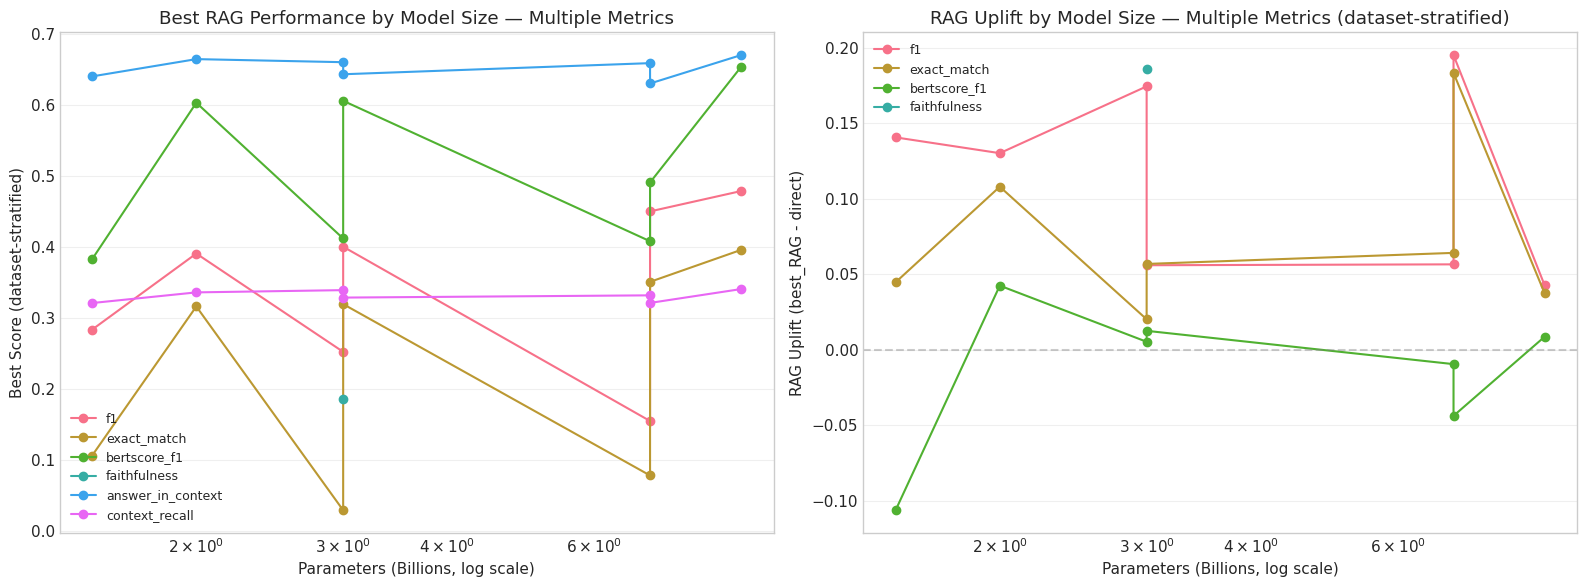

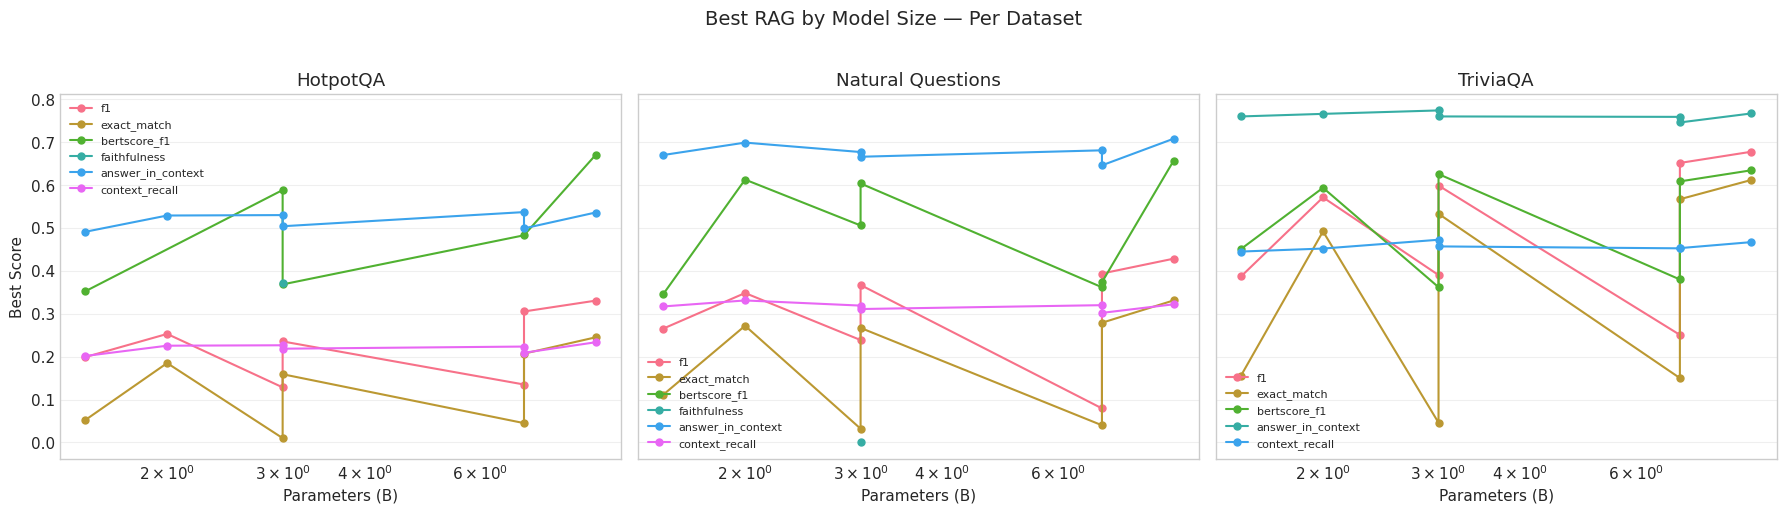

In [13]:
# Multi-metric scaling: best RAG performance per model across metrics (dataset-stratified)
scaling_metrics = [m for m in available_metrics if m != 'hallucination']  # hallucination is inverted
rag_df = df[df['exp_type'] == 'rag'].dropna(subset=['params_b'])

if len(scaling_metrics) >= 2 and not rag_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: Best RAG per model across metrics (stratified by dataset)
    ax = axes[0]
    for metric in scaling_metrics:
        metric_data = rag_df.dropna(subset=[metric])
        if metric_data.empty:
            continue
        # Per (model, dataset) best, then average across datasets
        per_ds_best = metric_data.groupby(['model_short', 'dataset'])[metric].max()
        model_best = per_ds_best.groupby('model_short').mean()
        params_map = metric_data.groupby('model_short')['params_b'].first()
        plot_df = pd.DataFrame({'best': model_best, 'params_b': params_map}).dropna().sort_values('params_b')
        ax.plot(plot_df['params_b'], plot_df['best'], 'o-', label=metric, markersize=6)

    ax.set_xscale('log')
    ax.set_xlabel('Parameters (Billions, log scale)')
    ax.set_ylabel('Best Score (dataset-stratified)')
    ax.set_title('Best RAG Performance by Model Size — Multiple Metrics')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    # Right: RAG uplift (best_rag - direct) per model across metrics (stratified)
    ax2 = axes[1]
    direct_df = df[df['exp_type'] == 'direct'].dropna(subset=['params_b'])

    for metric in scaling_metrics:
        # Stratified direct means: per (model, dataset) then average across datasets
        d_per_ds = direct_df.dropna(subset=[metric]).groupby(['model_short', 'dataset'])[metric].mean()
        d_means = d_per_ds.groupby('model_short').mean()
        d_params = direct_df.groupby('model_short')['params_b'].first()

        # Stratified RAG best: per (model, dataset) then average across datasets
        r_per_ds = rag_df.dropna(subset=[metric]).groupby(['model_short', 'dataset'])[metric].max()
        r_best = r_per_ds.groupby('model_short').mean()

        merged = pd.DataFrame({
            'direct_mean': d_means, 'best_rag': r_best, 'params_b': d_params,
        }).dropna()
        merged['uplift'] = merged['best_rag'] - merged['direct_mean']
        merged = merged.sort_values('params_b')

        if not merged.empty:
            ax2.plot(merged['params_b'], merged['uplift'], 'o-', label=metric, markersize=6)

    ax2.set_xscale('log')
    ax2.axhline(y=0, color='grey', ls='--', alpha=0.4)
    ax2.set_xlabel('Parameters (Billions, log scale)')
    ax2.set_ylabel('RAG Uplift (best_RAG - direct)')
    ax2.set_title('RAG Uplift by Model Size — Multiple Metrics (dataset-stratified)')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- Per-dataset faceted: multi-metric scaling per dataset ---
    datasets = sorted(rag_df['dataset'].unique())
    if len(datasets) >= 2:
        fig, axes_ds = plt.subplots(1, len(datasets),
                                    figsize=(6 * len(datasets), 5), sharey=True)
        if len(datasets) == 1:
            axes_ds = [axes_ds]

        for ax_i, ds in zip(axes_ds, datasets):
            ds_rag = rag_df[rag_df['dataset'] == ds]
            for metric in scaling_metrics:
                md = ds_rag.dropna(subset=[metric])
                if md.empty:
                    continue
                model_best = md.groupby('model_short').agg(
                    params_b=('params_b', 'first'),
                    best=(metric, 'max'),
                ).sort_values('params_b')
                ax_i.plot(model_best['params_b'], model_best['best'],
                          'o-', label=metric, markersize=5)

            ax_i.set_xscale('log')
            ax_i.set_xlabel('Parameters (B)')
            if ax_i is axes_ds[0]:
                ax_i.set_ylabel('Best Score')
            ax_i.set_title(DATASET_LABELS.get(ds, ds))
            ax_i.legend(fontsize=8)
            ax_i.grid(alpha=0.3)

        fig.suptitle('Best RAG by Model Size — Per Dataset', y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()
else:
    print("Not enough metrics with data for multi-metric scaling analysis.")

## 3. Can Small+RAG Match Medium+Direct?

For each tier, compare best-RAG performance against the direct performance of the next tier up.

(All values are dataset-stratified means)


,tier,tiny_direct,tiny_best_rag,small_direct,compensation_ratio,can_match,small_best_rag,medium_direct
0,tiny,0.2018,0.3909,0.2112,1.8504,True,NaN,NaN
1,small,NaN,NaN,0.2112,1.5216,True,0.4005,0.2632


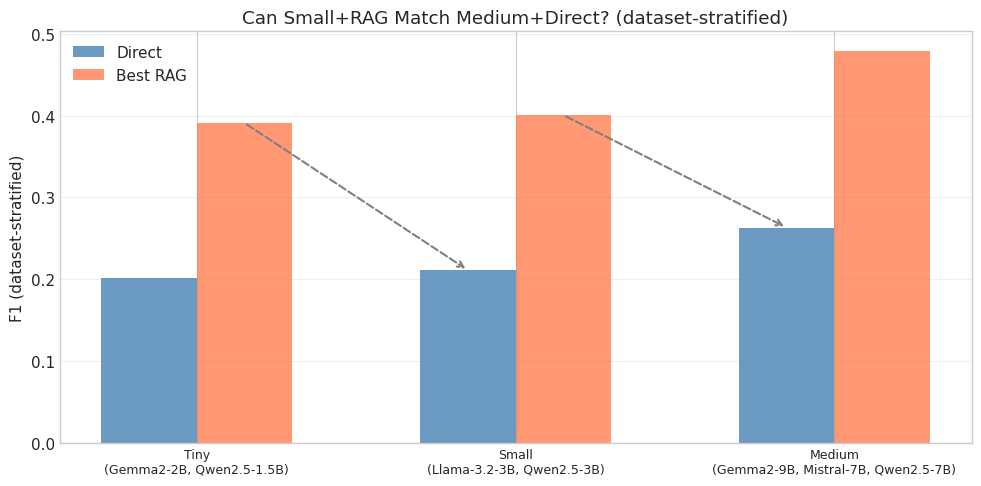

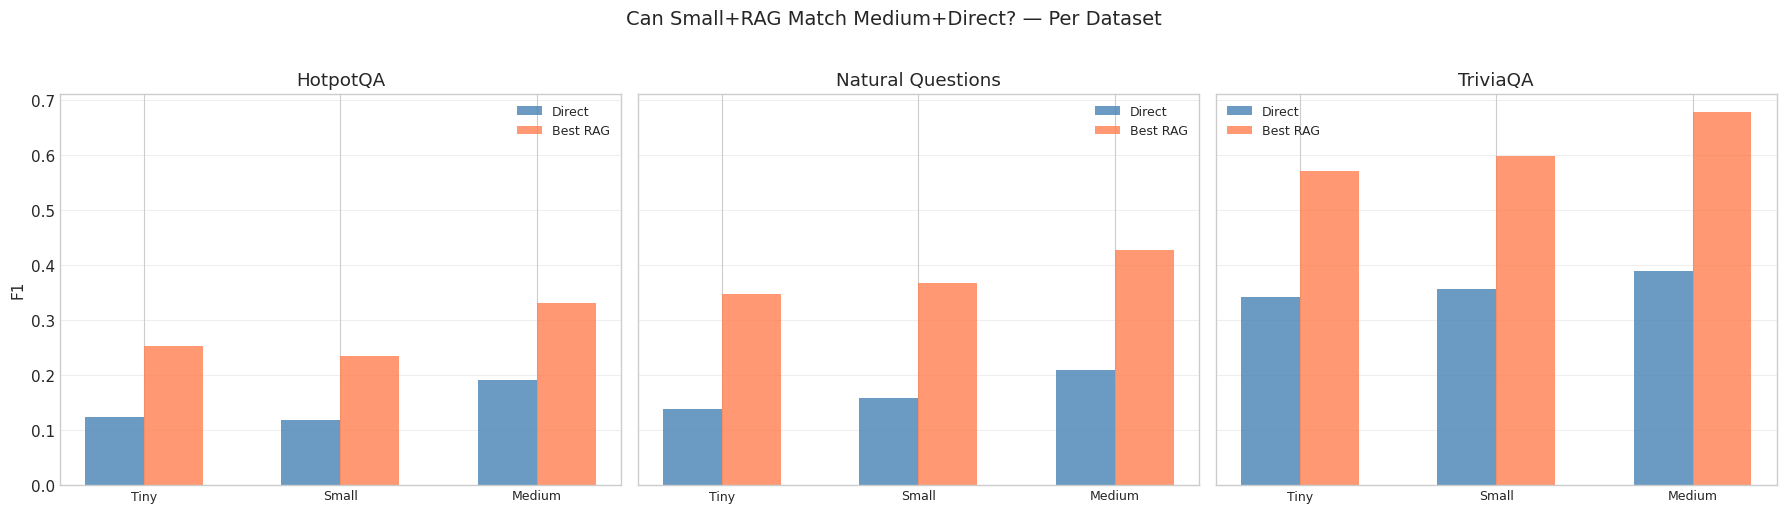

In [14]:
# Tier comparison using dataset-stratified scaling table (built in cell-5)
tier_order = ['tiny', 'small', 'medium']
tier_direct = {}
tier_best_rag = {}

for tier in tier_order:
    tier_models = scaling[scaling['tier'] == tier]
    if not tier_models.empty:
        tier_direct[tier] = tier_models['direct_f1'].mean()
        tier_best_rag[tier] = tier_models['best_rag_f1'].max()

comparison_rows = []
for i, tier in enumerate(tier_order[:-1]):
    next_tier = tier_order[i + 1]
    if tier in tier_best_rag and next_tier in tier_direct:
        rag_perf = tier_best_rag[tier]
        next_direct = tier_direct[next_tier]
        ratio = rag_perf / next_direct if next_direct > 0 else np.nan
        comparison_rows.append({
            'tier': tier,
            f'{tier}_direct': tier_direct.get(tier, np.nan),
            f'{tier}_best_rag': rag_perf,
            f'{next_tier}_direct': next_direct,
            'compensation_ratio': ratio,
            'can_match': rag_perf >= next_direct,
        })

comp_df = pd.DataFrame(comparison_rows)
print("(All values are dataset-stratified means)")
display(comp_df.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(tier_order))
w = 0.3

direct_vals = [tier_direct.get(t, 0) for t in tier_order]
rag_vals = [tier_best_rag.get(t, 0) for t in tier_order]

ax.bar(x - w/2, direct_vals, w, label='Direct', color='steelblue', alpha=0.8)
ax.bar(x + w/2, rag_vals, w, label='Best RAG', color='coral', alpha=0.8)

# Draw arrows showing compensation
for i in range(len(tier_order) - 1):
    if rag_vals[i] > 0 and direct_vals[i+1] > 0:
        ax.annotate('', xy=(x[i+1] - w/2, direct_vals[i+1]),
                    xytext=(x[i] + w/2, rag_vals[i]),
                    arrowprops=dict(arrowstyle='->', color='grey', lw=1.5, ls='--'))

ax.set_xticks(x)
ax.set_xticklabels([f"{t.capitalize()}\n({', '.join(scaling[scaling['tier']==t]['model_short'].tolist())})" for t in tier_order],
                    fontsize=9)
ax.set_ylabel('F1 (dataset-stratified)')
ax.set_title('Can Small+RAG Match Medium+Direct? (dataset-stratified)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Per-dataset faceted tier comparison ---
datasets = sorted(set(direct['dataset'].unique()) & set(rag_df['dataset'].unique()))
if len(datasets) >= 2:
    fig, axes_ds = plt.subplots(1, len(datasets),
                                figsize=(6 * len(datasets), 5), sharey=True)
    if len(datasets) == 1:
        axes_ds = [axes_ds]

    for ax_i, ds in zip(axes_ds, datasets):
        ds_direct = direct[direct['dataset'] == ds]
        ds_rag = rag_df[rag_df['dataset'] == ds]
        ds_d_vals = []
        ds_r_vals = []
        for tier in tier_order:
            tier_models_list = scaling[scaling['tier'] == tier]['model_short'].tolist()
            d_mean = ds_direct[ds_direct['model_short'].isin(tier_models_list)][PRIMARY_METRIC].mean()
            r_best = ds_rag[ds_rag['model_short'].isin(tier_models_list)][PRIMARY_METRIC].max()
            ds_d_vals.append(d_mean if not np.isnan(d_mean) else 0)
            ds_r_vals.append(r_best if not np.isnan(r_best) else 0)

        ax_i.bar(x - w/2, ds_d_vals, w, label='Direct', color='steelblue', alpha=0.8)
        ax_i.bar(x + w/2, ds_r_vals, w, label='Best RAG', color='coral', alpha=0.8)
        ax_i.set_xticks(x)
        ax_i.set_xticklabels([t.capitalize() for t in tier_order], fontsize=9)
        if ax_i is axes_ds[0]:
            ax_i.set_ylabel('F1')
        ax_i.set_title(DATASET_LABELS.get(ds, ds))
        ax_i.legend(fontsize=9)
        ax_i.grid(axis='y', alpha=0.3)

    fig.suptitle('Can Small+RAG Match Medium+Direct? — Per Dataset', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

## 4. What Matters for Small vs Medium Models?

Side-by-side variance decomposition for small and medium models.


Small models — variance explained:
  prompt              :  54.5%
  model_short         :  26.5%
  top_k               :   3.7%
  retriever_type      :   3.4%
  query_transform     :   2.8%
  reranker            :   2.2%
  embedding_model     :   0.8%

Medium models — variance explained:
  model_short         :  72.8%
  prompt              :  20.1%
  embedding_model     :   3.9%
  query_transform     :   2.3%
  top_k               :   1.3%
  reranker            :   1.2%
  retriever_type      :   1.1%


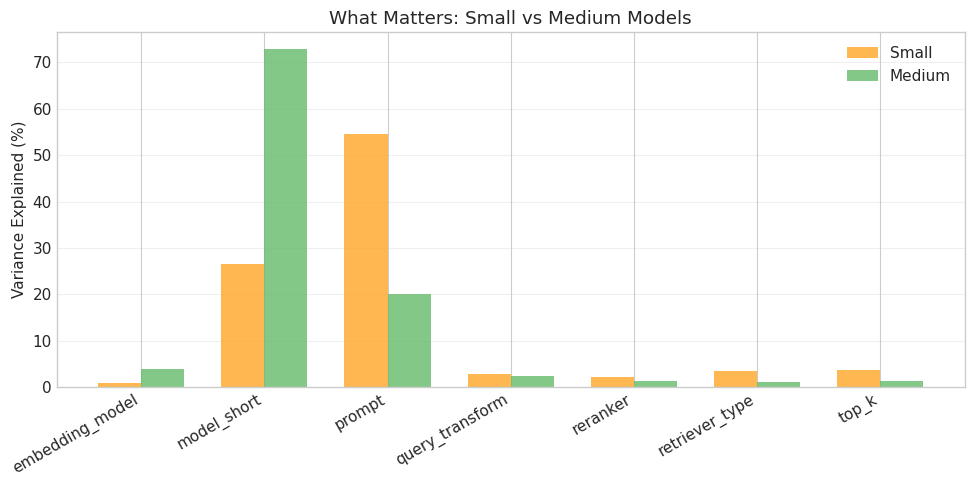


Tiny models — variance explained:
  model_short         :  48.1%
  prompt              :  37.7%
  top_k               :   6.6%
  query_transform     :   5.1%
  embedding_model     :   4.6%
  reranker            :   3.7%
  retriever_type      :   3.4%


In [15]:
tier_bottlenecks = {}
for tier in ['small', 'medium']:
    tier_df = df[(df['tier'] == tier) & (df['exp_type'] == 'rag')]
    if len(tier_df) >= 10:
        bn = identify_bottlenecks(tier_df, PRIMARY_METRIC)
        tier_bottlenecks[tier] = bn
        print(f"\n{tier.capitalize()} models — variance explained:")
        for factor, pct in bn.items():
            print(f"  {factor:<20s}: {pct:5.1f}%")

# Side-by-side bar chart
if len(tier_bottlenecks) >= 2:
    all_factors = sorted(set().union(*[bn.keys() for bn in tier_bottlenecks.values()]))

    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(all_factors))
    w = 0.35

    for i, (tier, bn) in enumerate(tier_bottlenecks.items()):
        vals = [bn.get(f, 0) for f in all_factors]
        color = '#ffa726' if tier == 'small' else '#66bb6a'
        ax.bar(x + (i - 0.5) * w, vals, w, label=tier.capitalize(), color=color, alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(all_factors, rotation=30, ha='right')
    ax.set_ylabel('Variance Explained (%)')
    ax.set_title('What Matters: Small vs Medium Models')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Also do tiny if available
tiny_df = df[(df['tier'] == 'tiny') & (df['exp_type'] == 'rag')]
if len(tiny_df) >= 10:
    bn = identify_bottlenecks(tiny_df, PRIMARY_METRIC)
    print(f"\nTiny models — variance explained:")
    for factor, pct in bn.items():
        print(f"  {factor:<20s}: {pct:5.1f}%")

## 5. Thesis Verdict

In [16]:
# Thesis verdict — uses dataset-stratified scaling table from cell-5
verdict_rows = []
for tier in tier_order:
    tier_models = scaling[scaling['tier'] == tier]
    if tier_models.empty:
        continue

    direct_mean = tier_models['direct_f1'].mean()
    best_rag = tier_models['best_rag_f1'].max()
    uplift = best_rag - direct_mean

    # Can this tier's best RAG match the next tier's direct?
    tier_idx = tier_order.index(tier)
    if tier_idx < len(tier_order) - 1:
        next_tier = tier_order[tier_idx + 1]
        next_direct = tier_direct.get(next_tier, np.nan)
        can_match = best_rag >= next_direct if not np.isnan(next_direct) else None
    else:
        can_match = 'N/A (largest tier)'

    verdict_rows.append({
        'tier': tier,
        'models': ', '.join(tier_models['model_short'].tolist()),
        'direct_f1': direct_mean,
        'best_rag_f1': best_rag,
        'rag_uplift': uplift,
        'can_match_next_tier': can_match,
    })

verdict_df = pd.DataFrame(verdict_rows)
print("THESIS VERDICT: Model Scaling Summary (dataset-stratified)")
print("=" * 70)
display(verdict_df.round(4))

THESIS VERDICT: Model Scaling Summary (dataset-stratified)


,tier,models,direct_f1,best_rag_f1,rag_uplift,can_match_next_tier
0,tiny,"Gemma2-2B, Qwen2.5-1.5B",0.2018,0.3909,0.1890,True
1,small,"Llama-3.2-3B, Qwen2.5-3B",0.2112,0.4005,0.1892,True
2,medium,"Gemma2-9B, Mistral-7B, Qwen2.5-7B",0.2632,0.4789,0.2157,N/A (largest tier)


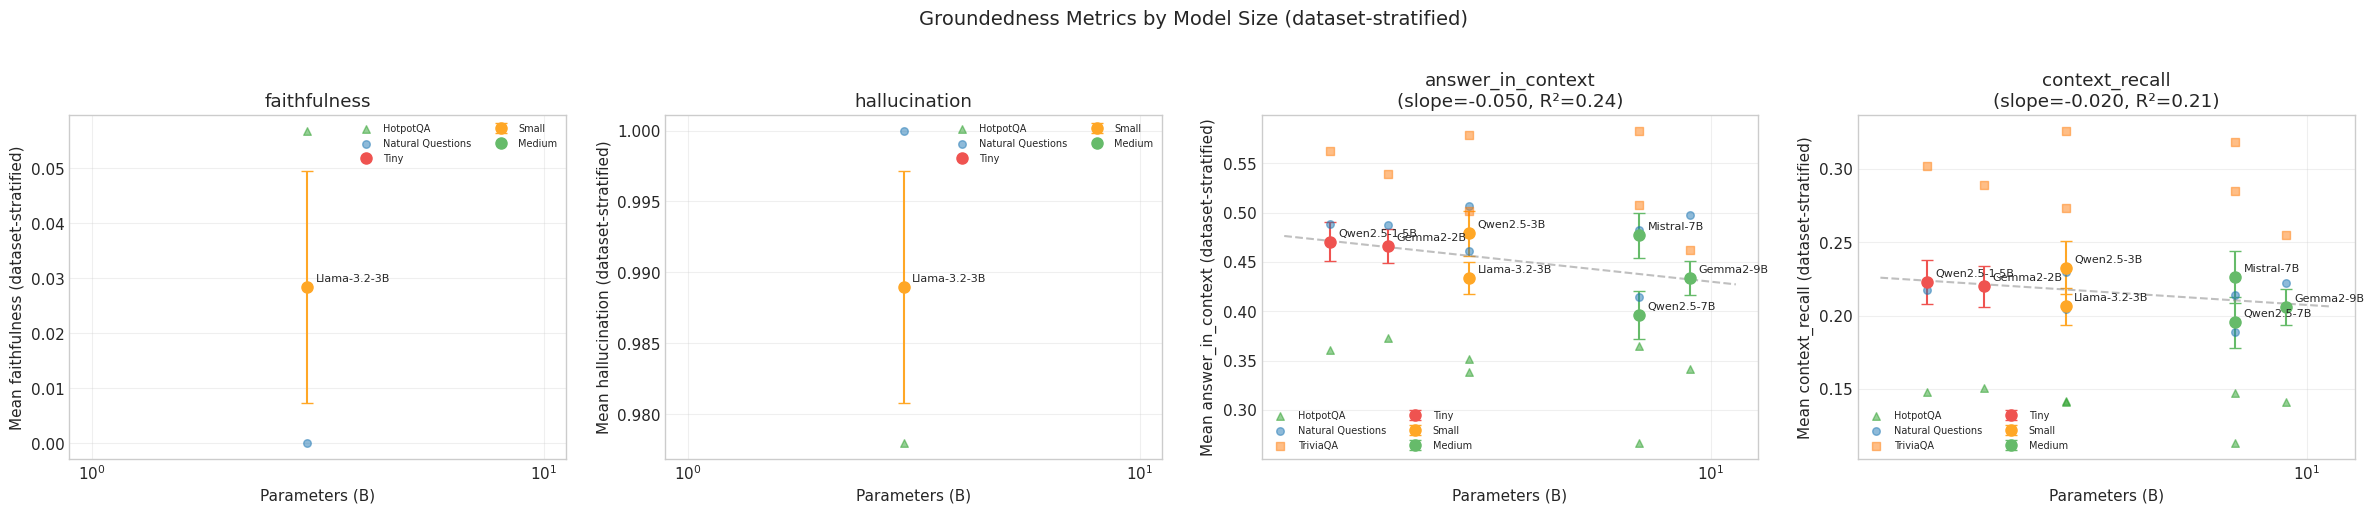


Groundedness by Model Tier (dataset-stratified means):

  faithfulness:
    tiny    : nan (n=0)
    small   : 0.028 (n=14)
    medium  : nan (n=0)

  hallucination:
    tiny    : nan (n=0)
    small   : 0.989 (n=14)
    medium  : nan (n=0)

  answer_in_context:
    tiny    : 0.468 (n=195)
    small   : 0.456 (n=203)
    medium  : 0.436 (n=271)

  context_recall:
    tiny    : 0.221 (n=195)
    small   : 0.219 (n=203)
    medium  : 0.209 (n=271)

  F1 vs Faithfulness scaling gap (dataset-stratified):
    tiny    : F1=0.216, faith=nan, gap=+nan
    small   : F1=0.210, faith=0.028, gap=-0.181
    medium  : F1=0.263, faith=nan, gap=+nan


In [17]:
rag_with_params = df[(df['exp_type'] == 'rag')].dropna(subset=['params_b']).copy()

groundedness_available = [m for m in ['faithfulness', 'hallucination', 'answer_in_context', 'context_recall']
                          if m in rag_with_params.columns and rag_with_params[m].notna().sum() >= 10]

if groundedness_available:
    n_metrics = len(groundedness_available)
    fig, axes = plt.subplots(1, n_metrics, figsize=(6 * n_metrics, 5))
    if n_metrics == 1:
        axes = [axes]

    for ax, metric in zip(axes, groundedness_available):
        metric_data = rag_with_params.dropna(subset=[metric])
        # Stratified: per (model, dataset) mean, then average across datasets
        per_ds = metric_data.groupby(['model_short', 'dataset'])[metric].mean()
        model_mean = per_ds.groupby('model_short').mean()
        model_std = per_ds.groupby('model_short').std().fillna(0)
        model_n = metric_data.groupby('model_short')[metric].count()
        model_stats = metric_data.groupby('model_short').agg(
            params_b=('params_b', 'first'),
            tier=('tier', 'first'),
        )
        model_stats['mean'] = model_mean
        model_stats['std'] = model_std
        model_stats['n'] = model_n
        model_stats = model_stats.sort_values('params_b')

        for tier, color in tier_colors.items():
            sub = model_stats[model_stats['tier'] == tier]
            ci = 1.96 * sub['std'] / np.sqrt(np.maximum(sub['n'], 1))
            ax.errorbar(sub['params_b'], sub['mean'], yerr=ci,
                       fmt='o', color=color, markersize=8, capsize=4,
                       label=tier.capitalize())
            for name, row in sub.iterrows():
                ax.annotate(name, (row['params_b'], row['mean']),
                           textcoords='offset points', xytext=(6, 4), fontsize=8)

        # Per-dataset small markers (secondary layer)
        for ds in sorted(metric_data['dataset'].unique()):
            ds_data = metric_data[metric_data['dataset'] == ds]
            ds_model = ds_data.groupby('model_short').agg(
                params_b=('params_b', 'first'),
                mean_val=(metric, 'mean'),
            )
            ds_color = DATASET_COLORS.get(ds, 'grey')
            ds_marker = DATASET_MARKERS.get(ds, 'x')
            ds_label = DATASET_LABELS.get(ds, ds)
            ax.scatter(ds_model['params_b'], ds_model['mean_val'],
                       marker=ds_marker, color=ds_color, s=30, alpha=0.5,
                       label=ds_label, zorder=2)

        # Trend line
        if len(model_stats) >= 3:
            log_p = np.log10(model_stats['params_b'])
            slope, intercept, r, p, _ = scipy_stats.linregress(log_p, model_stats['mean'])
            x_fit = np.linspace(log_p.min() - 0.1, log_p.max() + 0.1, 50)
            ax.plot(10**x_fit, slope * x_fit + intercept, '--', color='grey', alpha=0.5)
            ax.set_title(f'{metric}\n(slope={slope:.3f}, R\u00b2={r**2:.2f})')
        else:
            ax.set_title(metric)

        ax.set_xscale('log')
        ax.set_xlabel('Parameters (B)')
        ax.set_ylabel(f'Mean {metric} (dataset-stratified)')
        ax.legend(fontsize=7, ncol=2)
        ax.grid(alpha=0.3)

    plt.suptitle('Groundedness Metrics by Model Size (dataset-stratified)', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Summary table — stratified by dataset
    print("\nGroundedness by Model Tier (dataset-stratified means):")
    print("=" * 70)
    for metric in groundedness_available:
        # Per (tier, dataset) mean, then average across datasets per tier
        per_ds = rag_with_params.groupby(['tier', 'dataset'])[metric].mean()
        tier_means = per_ds.groupby('tier').mean()
        tier_counts = rag_with_params.groupby('tier')[metric].count()
        print(f"\n  {metric}:")
        for tier in ['tiny', 'small', 'medium']:
            if tier in tier_means.index:
                print(f"    {tier:<8s}: {tier_means[tier]:.3f} "
                      f"(n={int(tier_counts.get(tier, 0))})")

    # Key insight: does faithfulness scale differently from F1?
    if 'faithfulness' in groundedness_available and PRIMARY_METRIC in rag_with_params.columns:
        print("\n  F1 vs Faithfulness scaling gap (dataset-stratified):")
        for tier in ['tiny', 'small', 'medium']:
            t_data = rag_with_params[rag_with_params['tier'] == tier]
            if len(t_data) >= 5:
                # Stratified means
                f1_per_ds = t_data.groupby('dataset')[PRIMARY_METRIC].mean()
                faith_per_ds = t_data.groupby('dataset')['faithfulness'].mean()
                f1_mean = f1_per_ds.mean()
                faith_mean = faith_per_ds.mean()
                print(f"    {tier:<8s}: F1={f1_mean:.3f}, faith={faith_mean:.3f}, "
                      f"gap={faith_mean - f1_mean:+.3f}")
else:
    print("No groundedness metrics available. Run:")
    print("  uv run ragicamp compute-metrics outputs/smart_retrieval_slm "
          "-m faithfulness,hallucination,answer_in_context,context_recall")

## 5b. Faithfulness & Hallucination by Model Size

**Key safety question:** Do bigger models hallucinate less? Are smaller models less faithful to context?

This matters for deployment: if small models are equally faithful when given good context,
they may be safer than their F1 gap suggests.

## 6. Summary

Key takeaways:
- Direct performance scales with model size (log-linear relationship)
- RAG uplift magnitude vs model size
- Whether small+premium RAG can match medium+direct
- Different components matter for small vs medium models